In [1]:
#Importing the necessary packages
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from skimage.io import imsave, imread
from keras.optimizers import Adam
import tensorflow as tf


# Set some image parameters
resize_ht=128
resize_wdt=128
img_channels = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

/home/nischita/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Setting the data paths
data_dir = '/home/nischita/Desktop/AI_assignment'

input_img_dir = data_dir + '/melanoma/'
other_img_dir = data_dir + '/others/'
train_img_dir = data_dir + '/gt/'
total=len(os.listdir(input_img_dir))+len(os.listdir(other_img_dir))

In [22]:
#Function to load the testing and training data
def load_data():
    len_test_imgs = len(os.listdir(input_img_dir))
    len_train_imgs = len(os.listdir(other_img_dir))
    print('Total number of training images = ',len_train_imgs)
    print('Total number of testing images = ',len_test_imgs)
    imgs1=[]
    imgs_mask1=[]
    imgs2=[]
    imgs_mask2=[]
    i = 0
     
    #Loading the training data    
    train_images = os.listdir(other_img_dir)
    for img_name in train_images:
        img_mask_name = img_name.split('.')[0] 
        img_mask_name = img_mask_name +"_segmentation.png"
        image = cv2.imread(os.path.join(other_img_dir, img_name))
        image = cv2.resize(image, (resize_ht, resize_wdt))
        img_mask = cv2.imread(os.path.join(train_img_dir, img_mask_name),-1)
        print(img_mask.shape)
        img_mask=cv2.resize(img_mask,(resize_ht,resize_wdt))
        print(img_mask.shape)
        image = img_to_array(image)
        img_mask=img_to_array(img_mask)
        imgs1.append(image)
        imgs_mask1.append(img_mask)
       

        print('Done: {0}/{1} images'.format(i, len_train_imgs))
        i += 1
        
    i = 0
    
    #Loading the testing data
    test_images = os.listdir(input_img_dir)
    for img_name in test_images:
        img_mask_name = img_name.split('.')[0]
        img_mask_name = img_mask_name+"_segmentation.png"
        image = cv2.imread(os.path.join(input_img_dir, img_name))
        image = cv2.resize(image, (resize_ht, resize_wdt))
        img_mask = cv2.imread(os.path.join(train_img_dir, img_mask_name),-1)
        img_mask=cv2.resize(img_mask,(resize_ht,resize_wdt))
        image = img_to_array(image)
        img_mask=img_to_array(img_mask)
        imgs2.append(image)
        imgs_mask2.append(img_mask)
       
        print('Done: {0}/{1} images'.format(i, len_test_imgs))
        i += 1
        
    print('out of for')
    imgs1 = np.array(imgs1, dtype="float")/255.0
    imgs_mask1 = np.array(imgs_mask1,dtype="float")/255.0
    imgs2 = np.array(imgs2, dtype="float")/255.0
    imgs_mask2= np.array(imgs_mask2,dtype="float")/255.0
    print('Loading done.')
    return imgs1, imgs_mask1, imgs2, imgs_mask2


In [25]:
#Loading the data
trainingX, trainingY, testingX, testingY = load_data()
np.save( 'imgs_train.npy', trainingX)
np.save('imgs_mask_train.npy', trainingY)
np.save( 'imgs_test.npy', testingX)
np.save('imgs_mask_test.npy', testingY)

Total number of training images =  1626
Total number of testing images =  374
(2000, 3008)
(128, 128)
Done: 0/1626 images
(2848, 4288)
(128, 128)
Done: 1/1626 images
(2000, 3008)
(128, 128)
Done: 2/1626 images
(2848, 4288)
(128, 128)
Done: 3/1626 images
(1536, 2048)
(128, 128)
Done: 4/1626 images
(2000, 3008)
(128, 128)
Done: 5/1626 images
(2016, 3024)
(128, 128)
Done: 6/1626 images
(2848, 4288)
(128, 128)
Done: 7/1626 images
(768, 1024)
(128, 128)
Done: 8/1626 images
(768, 1024)
(128, 128)
Done: 9/1626 images
(719, 824)
(128, 128)
Done: 10/1626 images
(2067, 2314)
(128, 128)
Done: 11/1626 images
(2000, 3008)
(128, 128)
Done: 12/1626 images
(768, 1024)
(128, 128)
Done: 13/1626 images
(2592, 3872)
(128, 128)
Done: 14/1626 images
(768, 1024)
(128, 128)
Done: 15/1626 images
(2592, 3872)
(128, 128)
Done: 16/1626 images
(768, 1024)
(128, 128)
Done: 17/1626 images
(4441, 6641)
(128, 128)
Done: 18/1626 images
(2304, 3072)
(128, 128)
Done: 19/1626 images
(2848, 4288)
(128, 128)
Done: 20/1626 i

(2848, 4288)
(128, 128)
Done: 181/1626 images
(2000, 3008)
(128, 128)
Done: 182/1626 images
(2000, 3008)
(128, 128)
Done: 183/1626 images
(768, 1024)
(128, 128)
Done: 184/1626 images
(768, 1024)
(128, 128)
Done: 185/1626 images
(4439, 6708)
(128, 128)
Done: 186/1626 images
(768, 1024)
(128, 128)
Done: 187/1626 images
(2848, 4288)
(128, 128)
Done: 188/1626 images
(2848, 4288)
(128, 128)
Done: 189/1626 images
(2304, 3072)
(128, 128)
Done: 190/1626 images
(768, 1024)
(128, 128)
Done: 191/1626 images
(2016, 3024)
(128, 128)
Done: 192/1626 images
(1536, 2048)
(128, 128)
Done: 193/1626 images
(767, 1022)
(128, 128)
Done: 194/1626 images
(2000, 3008)
(128, 128)
Done: 195/1626 images
(2000, 3008)
(128, 128)
Done: 196/1626 images
(1129, 1504)
(128, 128)
Done: 197/1626 images
(2848, 4288)
(128, 128)
Done: 198/1626 images
(768, 1024)
(128, 128)
Done: 199/1626 images
(2848, 4288)
(128, 128)
Done: 200/1626 images
(2848, 4288)
(128, 128)
Done: 201/1626 images
(2000, 3008)
(128, 128)
Done: 202/1626 i

(1936, 2592)
(128, 128)
Done: 363/1626 images
(768, 1024)
(128, 128)
Done: 364/1626 images
(1936, 2592)
(128, 128)
Done: 365/1626 images
(2848, 4288)
(128, 128)
Done: 366/1626 images
(1958, 2155)
(128, 128)
Done: 367/1626 images
(2304, 3072)
(128, 128)
Done: 368/1626 images
(2848, 4288)
(128, 128)
Done: 369/1626 images
(2016, 3024)
(128, 128)
Done: 370/1626 images
(2000, 3008)
(128, 128)
Done: 371/1626 images
(768, 1024)
(128, 128)
Done: 372/1626 images
(1536, 2048)
(128, 128)
Done: 373/1626 images
(2000, 3008)
(128, 128)
Done: 374/1626 images
(2304, 3072)
(128, 128)
Done: 375/1626 images
(4441, 6641)
(128, 128)
Done: 376/1626 images
(2000, 3008)
(128, 128)
Done: 377/1626 images
(2000, 3008)
(128, 128)
Done: 378/1626 images
(2000, 3008)
(128, 128)
Done: 379/1626 images
(768, 1024)
(128, 128)
Done: 380/1626 images
(4402, 6581)
(128, 128)
Done: 381/1626 images
(1944, 2592)
(128, 128)
Done: 382/1626 images
(768, 1024)
(128, 128)
Done: 383/1626 images
(2848, 4288)
(128, 128)
Done: 384/1626

(4439, 6708)
(128, 128)
Done: 543/1626 images
(2000, 3008)
(128, 128)
Done: 544/1626 images
(2848, 4288)
(128, 128)
Done: 545/1626 images
(768, 1024)
(128, 128)
Done: 546/1626 images
(2000, 3008)
(128, 128)
Done: 547/1626 images
(2000, 3008)
(128, 128)
Done: 548/1626 images
(2000, 3008)
(128, 128)
Done: 549/1626 images
(768, 1024)
(128, 128)
Done: 550/1626 images
(704, 1057)
(128, 128)
Done: 551/1626 images
(768, 576)
(128, 128)
Done: 552/1626 images
(768, 1024)
(128, 128)
Done: 553/1626 images
(2000, 3008)
(128, 128)
Done: 554/1626 images
(4441, 6642)
(128, 128)
Done: 555/1626 images
(4422, 6642)
(128, 128)
Done: 556/1626 images
(2592, 3872)
(128, 128)
Done: 557/1626 images
(802, 919)
(128, 128)
Done: 558/1626 images
(4382, 6682)
(128, 128)
Done: 559/1626 images
(802, 919)
(128, 128)
Done: 560/1626 images
(2848, 4288)
(128, 128)
Done: 561/1626 images
(4441, 6661)
(128, 128)
Done: 562/1626 images
(2848, 4288)
(128, 128)
Done: 563/1626 images
(4439, 6668)
(128, 128)
Done: 564/1626 image

(2000, 3008)
(128, 128)
Done: 724/1626 images
(767, 1022)
(128, 128)
Done: 725/1626 images
(4441, 6621)
(128, 128)
Done: 726/1626 images
(1051, 1502)
(128, 128)
Done: 727/1626 images
(2000, 3008)
(128, 128)
Done: 728/1626 images
(2848, 4288)
(128, 128)
Done: 729/1626 images
(2848, 4288)
(128, 128)
Done: 730/1626 images
(2000, 3008)
(128, 128)
Done: 731/1626 images
(2848, 4288)
(128, 128)
Done: 732/1626 images
(576, 767)
(128, 128)
Done: 733/1626 images
(2848, 4256)
(128, 128)
Done: 734/1626 images
(802, 919)
(128, 128)
Done: 735/1626 images
(4499, 6748)
(128, 128)
Done: 736/1626 images
(2000, 3008)
(128, 128)
Done: 737/1626 images
(576, 767)
(128, 128)
Done: 738/1626 images
(1936, 2592)
(128, 128)
Done: 739/1626 images
(2848, 4288)
(128, 128)
Done: 740/1626 images
(768, 1024)
(128, 128)
Done: 741/1626 images
(2592, 3872)
(128, 128)
Done: 742/1626 images
(576, 767)
(128, 128)
Done: 743/1626 images
(2848, 4288)
(128, 128)
Done: 744/1626 images
(2848, 4288)
(128, 128)
Done: 745/1626 image

(2592, 3872)
(128, 128)
Done: 906/1626 images
(576, 767)
(128, 128)
Done: 907/1626 images
(768, 1024)
(128, 128)
Done: 908/1626 images
(768, 1024)
(128, 128)
Done: 909/1626 images
(768, 1024)
(128, 128)
Done: 910/1626 images
(4439, 6648)
(128, 128)
Done: 911/1626 images
(768, 1024)
(128, 128)
Done: 912/1626 images
(2848, 4288)
(128, 128)
Done: 913/1626 images
(2848, 4288)
(128, 128)
Done: 914/1626 images
(2592, 3872)
(128, 128)
Done: 915/1626 images
(4422, 6642)
(128, 128)
Done: 916/1626 images
(2016, 3024)
(128, 128)
Done: 917/1626 images
(576, 767)
(128, 128)
Done: 918/1626 images
(1129, 1504)
(128, 128)
Done: 919/1626 images
(2016, 3024)
(128, 128)
Done: 920/1626 images
(768, 1024)
(128, 128)
Done: 921/1626 images
(2016, 3024)
(128, 128)
Done: 922/1626 images
(576, 767)
(128, 128)
Done: 923/1626 images
(1936, 2592)
(128, 128)
Done: 924/1626 images
(2082, 2725)
(128, 128)
Done: 925/1626 images
(768, 1024)
(128, 128)
Done: 926/1626 images
(2848, 4288)
(128, 128)
Done: 927/1626 images


(2592, 3872)
(128, 128)
Done: 1087/1626 images
(2000, 3008)
(128, 128)
Done: 1088/1626 images
(2592, 3872)
(128, 128)
Done: 1089/1626 images
(4381, 6602)
(128, 128)
Done: 1090/1626 images
(768, 1024)
(128, 128)
Done: 1091/1626 images
(2592, 3872)
(128, 128)
Done: 1092/1626 images
(2000, 3008)
(128, 128)
Done: 1093/1626 images
(2592, 3872)
(128, 128)
Done: 1094/1626 images
(2000, 3008)
(128, 128)
Done: 1095/1626 images
(2000, 3008)
(128, 128)
Done: 1096/1626 images
(768, 1024)
(128, 128)
Done: 1097/1626 images
(768, 1024)
(128, 128)
Done: 1098/1626 images
(2848, 4288)
(128, 128)
Done: 1099/1626 images
(768, 1024)
(128, 128)
Done: 1100/1626 images
(1936, 2592)
(128, 128)
Done: 1101/1626 images
(768, 1024)
(128, 128)
Done: 1102/1626 images
(722, 962)
(128, 128)
Done: 1103/1626 images
(2848, 4288)
(128, 128)
Done: 1104/1626 images
(2592, 3872)
(128, 128)
Done: 1105/1626 images
(768, 1024)
(128, 128)
Done: 1106/1626 images
(2016, 3024)
(128, 128)
Done: 1107/1626 images
(768, 1024)
(128, 128

(2848, 4288)
(128, 128)
Done: 1264/1626 images
(2848, 4288)
(128, 128)
Done: 1265/1626 images
(2848, 4288)
(128, 128)
Done: 1266/1626 images
(768, 1024)
(128, 128)
Done: 1267/1626 images
(2000, 3008)
(128, 128)
Done: 1268/1626 images
(768, 1024)
(128, 128)
Done: 1269/1626 images
(768, 1024)
(128, 128)
Done: 1270/1626 images
(2000, 3008)
(128, 128)
Done: 1271/1626 images
(2848, 4288)
(128, 128)
Done: 1272/1626 images
(2000, 3008)
(128, 128)
Done: 1273/1626 images
(768, 1024)
(128, 128)
Done: 1274/1626 images
(2000, 3008)
(128, 128)
Done: 1275/1626 images
(2000, 3008)
(128, 128)
Done: 1276/1626 images
(768, 1024)
(128, 128)
Done: 1277/1626 images
(2848, 4288)
(128, 128)
Done: 1278/1626 images
(2848, 4288)
(128, 128)
Done: 1279/1626 images
(2304, 3072)
(128, 128)
Done: 1280/1626 images
(2848, 4288)
(128, 128)
Done: 1281/1626 images
(768, 1024)
(128, 128)
Done: 1282/1626 images
(1129, 1504)
(128, 128)
Done: 1283/1626 images
(2016, 3024)
(128, 128)
Done: 1284/1626 images
(1988, 2117)
(128, 

(2016, 3024)
(128, 128)
Done: 1442/1626 images
(2848, 4288)
(128, 128)
Done: 1443/1626 images
(768, 1024)
(128, 128)
Done: 1444/1626 images
(719, 824)
(128, 128)
Done: 1445/1626 images
(2848, 4288)
(128, 128)
Done: 1446/1626 images
(767, 1022)
(128, 128)
Done: 1447/1626 images
(2848, 4288)
(128, 128)
Done: 1448/1626 images
(768, 1024)
(128, 128)
Done: 1449/1626 images
(2000, 3008)
(128, 128)
Done: 1450/1626 images
(2848, 4288)
(128, 128)
Done: 1451/1626 images
(768, 1024)
(128, 128)
Done: 1452/1626 images
(1129, 1504)
(128, 128)
Done: 1453/1626 images
(2848, 4288)
(128, 128)
Done: 1454/1626 images
(1536, 2048)
(128, 128)
Done: 1455/1626 images
(2848, 4288)
(128, 128)
Done: 1456/1626 images
(768, 1024)
(128, 128)
Done: 1457/1626 images
(2016, 3024)
(128, 128)
Done: 1458/1626 images
(768, 1024)
(128, 128)
Done: 1459/1626 images
(768, 1024)
(128, 128)
Done: 1460/1626 images
(767, 1022)
(128, 128)
Done: 1461/1626 images
(1129, 1504)
(128, 128)
Done: 1462/1626 images
(2848, 4288)
(128, 128)

(2592, 3872)
(128, 128)
Done: 1620/1626 images
(2000, 3008)
(128, 128)
Done: 1621/1626 images
(1536, 2048)
(128, 128)
Done: 1622/1626 images
(2848, 4288)
(128, 128)
Done: 1623/1626 images
(2848, 4288)
(128, 128)
Done: 1624/1626 images
(2848, 4288)
(128, 128)
Done: 1625/1626 images
Done: 0/374 images
Done: 1/374 images
Done: 2/374 images
Done: 3/374 images
Done: 4/374 images
Done: 5/374 images
Done: 6/374 images
Done: 7/374 images
Done: 8/374 images
Done: 9/374 images
Done: 10/374 images
Done: 11/374 images
Done: 12/374 images
Done: 13/374 images
Done: 14/374 images
Done: 15/374 images
Done: 16/374 images
Done: 17/374 images
Done: 18/374 images
Done: 19/374 images
Done: 20/374 images
Done: 21/374 images
Done: 22/374 images
Done: 23/374 images
Done: 24/374 images
Done: 25/374 images
Done: 26/374 images
Done: 27/374 images
Done: 28/374 images
Done: 29/374 images
Done: 30/374 images
Done: 31/374 images
Done: 32/374 images
Done: 33/374 images
Done: 34/374 images
Done: 35/374 images
Done: 36

/home/nischita/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


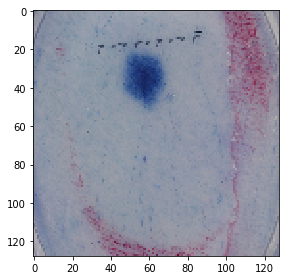

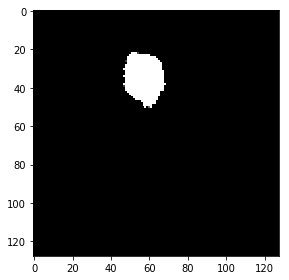

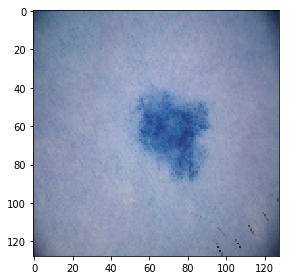

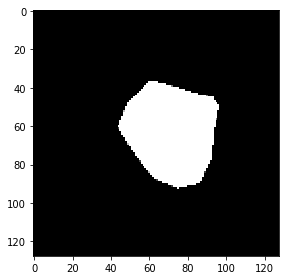

In [26]:
#To check if the testing and training data are loaded correctly
ix = random.randint(0, 0.75*total)
imshow(trainingX[ix])
plt.show()
imshow(np.squeeze(trainingY[ix]))
plt.show()

ix = random.randint(0, 0.25*total)
imshow(testingX[ix])
plt.show()
imshow(np.squeeze(testingY[ix]))
plt.show()

In [27]:
smooth = 1.

#Defiine dice coefficient and the corresponding loss function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [7]:
#Define the model based on unet architechture

inputs = Input((resize_ht, resize_wdt, img_channels))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same') (conv1)
pool1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same') (pool1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same') (conv2)
pool2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same') (pool2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same') (conv3)
pool3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same') (pool3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same') (conv4)
pool4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool4)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same') (conv5)

upsample6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same') (upsample6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same') (conv6)

upsample7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same') (upsample7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same') (conv7)

upsample8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same') (upsample8)
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same') (conv8)

upsample9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same') (upsample9)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same') (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef,'accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [8]:
# Training the  model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(trainingX, trainingY, validation_split=0.1, batch_size=8, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 1463 samples, validate on 163 samples
Epoch 1/10
1463/1463 [==============================] - 352s 241ms/step - loss: -0.5510 - dice_coef: 0.5510 - acc: 0.7311 - val_loss: -0.6613 - val_dice_coef: 0.6613 - val_acc: 0.8615

Epoch 00001: val_loss improved from inf to -0.66126, saving model to model-dsbowl2018-1.h5
Epoch 2/10
1463/1463 [==============================] - 277s 190ms/step - loss: -0.7444 - dice_coef: 0.7444 - acc: 0.9112 - val_loss: -0.7304 - val_dice_coef: 0.7304 - val_acc: 0.9053

Epoch 00002: val_loss improved from -0.66126 to -0.73043, saving model to model-dsbowl2018-1.h5
Epoch 3/10
1463/1463 [==============================] - 267s 182ms/step - loss: -0.8039 - dice_coef: 0.8039 - acc: 0.9335 - val_loss: -0.7779 - val_dice_coef: 0.7779 - val_acc: 0.9310

Epoch 00003: val_loss improved from -0.73043 to -0.77787, saving model to model-dsbowl2018-1.h5
Epoch 4/10
1463/1463 [==============================] - 264s 181ms/step - loss: -0.8264 - dice_coef: 0.8264 - acc: 

In [12]:
score = model.evaluate(testingX,testingY)

374/374 [==============================] - 10s 26ms/step


In [14]:
#Displaying testing accuracy
print(score[1]*100)

85.93235784035953


In [26]:
out_image = model.predict(testingX,verbose="True") 
print(out_image.shape)
print('max    value..')
print(max(out_image[4].flatten()))
image = out_image[4]
image[image > 0.5] = 1.
image[image <= 0.5] = 0

cv2.imwrite("predicted_image.png",image)
img = cv2.imread('/home/predicted_image.png',0)

(374, 128, 128, 1)
max    value..
1.0


/home/nischita/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


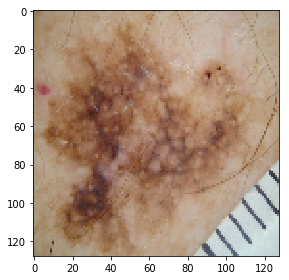

In [27]:
#displaying the original image
imshow(testingX[4])
plt.show()

/home/nischita/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


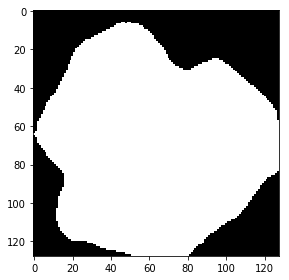

In [28]:
#Displaying the segmented image
imshow(np.squeeze(image))
plt.show()